In [14]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [16]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [17]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('content.jpg', img_transform)
style_img = get_image('style.jpg', img_transform)
generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False

In [18]:
content_weight = 1
style_weight = 100

for epoch in range(1000):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) 

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 22399.0352
Epoch [100]	Content Loss: 4.7341	Style Loss: 11650.5850
Epoch [200]	Content Loss: 5.0022	Style Loss: 6747.9292
Epoch [300]	Content Loss: 5.1135	Style Loss: 4433.1870
Epoch [400]	Content Loss: 5.2588	Style Loss: 3204.3538
Epoch [500]	Content Loss: 5.3862	Style Loss: 2511.8535
Epoch [600]	Content Loss: 5.5023	Style Loss: 2074.3916
Epoch [700]	Content Loss: 5.5737	Style Loss: 1764.0750
Epoch [800]	Content Loss: 5.6352	Style Loss: 1526.7061
Epoch [900]	Content Loss: 5.6853	Style Loss: 1337.6267


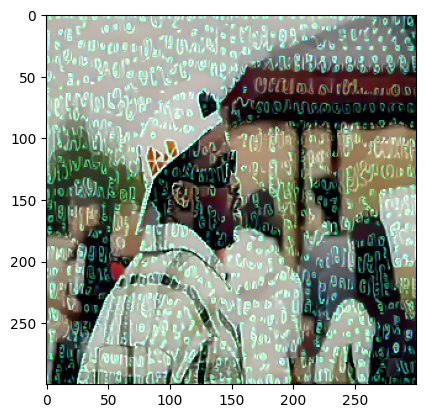

In [19]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)